# 9: intraday correlations

In [1]:
import numpy as np
import pandas as pd

import re

def load_TRTH_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
    try:
        if re.search('(csv|csv\\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search('parquet$',filename):
            DF = pd.read_parquet(filename)

    except Exception as e:
     #   print("load_TRTH_trade could not load "+filename)
     #   print(e)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    
    if DF.shape[0]==0:
        return None
    
    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]

    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
    
    return DF


def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             only_regular_trading_hours=True,
             merge_sub_trades=True):
    try:
        if re.search(r'(csv|csv\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search(r'parquet$',filename):
            DF = pd.read_parquet(filename) 
    except Exception as e:
        print("load_TRTH_bbo could not load "+filename+" "+e)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    if DF.shape[0]==0:
        return None
    
        
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time("09:30:00","16:00:00")    # ever heard about Thanksgivings?
        
    if merge_sub_trades:
        DF=DF.groupby(DF.index).last()
    

        
    return DF

## 1. Epps effect

In [2]:
bbo1   = load_TRTH_bbo("data/raw/TRTH/equities/US/bbo/SPY.P/2017-01-03-SPY.P-bbo.parquet")
bbo2   = load_TRTH_bbo("data/raw/TRTH/equities/US/bbo/AAPL.OQ/2017-01-03-AAPL.OQ-bbo.parquet")


In [4]:
def get_logret_binned_from_bbo(bbo,resample_period):
    mid=0.5*(bbo["bid-price"]+bbo["ask-price"])
    mid=mid.resample(resample_period).last().ffill()
    logret_mid=np.log(mid).diff()
    return pd.DataFrame(logret_mid)

delta_ts=np.arange(1,10000,10)

Cs=[]
for delta_t in delta_ts:
    resample_period=str(delta_t)+"L"
    logret1=get_logret_binned_from_bbo(bbo1,resample_period)
    logret2=get_logret_binned_from_bbo(bbo2,resample_period)
    Cs.append((np.nanmean(logret1*logret2)-np.nanmean(logret1)*np.nanmean(logret2))/np.nanstd(logret1)/np.nanstd(logret2))

Text(0, 0.5, 'correlation')

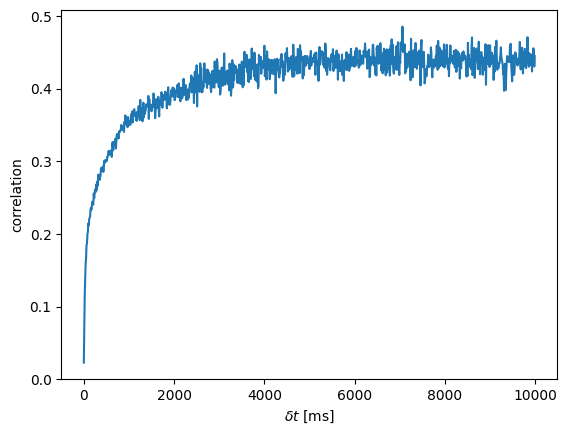

In [5]:
import matplotlib.pyplot as plt

plt.plot(delta_ts,Cs)
plt.xlabel(r'$\delta t$ [ms]')
plt.ylabel('correlation')

## 2. Hayashi-Yoshida estimator

In [6]:
def get_logret_mid_tick(filename):
    bbo   = load_TRTH_bbo(filename)
    mid=0.5*(bbo["bid-price"]+bbo["ask-price"])
    logret_mid=np.log(mid).diff()
    logret_mid=logret_mid[logret_mid!=0]
    return pd.DataFrame(logret_mid)


logret1   = get_logret_mid_tick("data/raw/TRTH/equities/US/bbo/SPY.P/2017-01-03-SPY.P-bbo.parquet")
logret2   = get_logret_mid_tick("data/raw/TRTH/equities/US/bbo/AAPL.OQ/2017-01-03-AAPL.OQ-bbo.parquet")
logret1.columns=["1"]
logret2.columns=["2"]


In [7]:
def HY_corr(logret1,logret2):
    logret12=pd.DataFrame(logret1).join(pd.DataFrame(logret2),how="outer")
    logret12.ffill(inplace=True)
    logret12.dropna(inplace=True)
    corr=((logret12["1"]*logret12["2"]).mean()-np.nanmean(logret1)*np.nanmean(logret2))/(np.nanstd(logret1)*np.nanstd(logret2))
    return corr

In [8]:
HY_corr(logret1,logret2)

0.14280795556388715

HY_corr is smaller than the asymptotic one because of two potential effects: non-Gaussianity (bias) and lead-lag effects